In [9]:
from src import util as util
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import collections
from pathlib import Path
import csv

In [10]:
def load_spam_dataset_csv(csv_path):

    messages = []
    labels = []

    with open(csv_path, 'r', newline='', encoding='utf8') as csv_file:
        reader = csv.reader(csv_file, delimiter=',')

        for message, label in reader:
            messages.append(message)
            labels.append(1 if label == '1' else 0)

    return messages, np.array(labels)

In [11]:
train_messages, train_labels = util.load_spam_dataset('data/train.tsv')
test_messages, test_labels = util.load_spam_dataset('data/test.tsv')
train2_messages, train2_labels = load_spam_dataset_csv('data/emails_new_train.csv')
val_messages, val_labels = util.load_spam_dataset('data/val.tsv')

In [12]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from tqdm import tqdm

# Initialize BERT (CPU-only)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()  # Disable dropout for inference

def get_bert_embeddings(email_bodies, batch_size=4):
    """Convert emails to BERT embeddings using PyTorch"""
    all_embeddings = []
    
    for i in tqdm(range(0, len(email_bodies), batch_size), 
                 desc="Processing emails"):
        batch_emails = email_bodies[i:i + batch_size]
        
        inputs = tokenizer(
            batch_emails,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=128
        )
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Use [CLS] token embedding as sentence representation
        cls_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
        all_embeddings.extend(cls_embeddings)
    
    return np.vstack(all_embeddings)


In [21]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')  # Load pre-trained model

In [28]:
embeddings_new_training = model.encode(train2_messages, convert_to_tensor=False)  # Returns NumPy array

In [25]:

sentences=[
"Don't forget to Subscribe our page in www.hh.com",
    
'Get new phone free Click this URL',
"Urgent your Account has been compromised. Verify your details now",
    "Making $5000 a week working from home. No Skills required",
"Your Package delivery failed. Click here to reschedule",
    "Act now this offer expires in 24 hours",
    "Get rich quick with this one simple trick",
    "Warning "
]
embeddings_new_test = model.encode(sentences, convert_to_tensor=False)  # Returns NumPy array

In [26]:
embeddings_new_test.shape

(8, 384)

In [13]:
embeddings_train = get_bert_embeddings(train_messages)

Processing emails: 100%|███████████████████████████████████████████████████████████| 1115/1115 [07:41<00:00,  2.42it/s]


In [15]:
embeddings_test = get_bert_embeddings(test_messages)

Processing emails: 100%|█████████████████████████████████████████████████████████████| 140/140 [00:35<00:00,  3.92it/s]


In [23]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svm = SVC(kernel='linear', random_state=42)  

# Train
svm.fit(embeddings_new_training, train2_labels)


SVC(kernel='linear', random_state=42)

In [27]:

# Predict
y_pred = svm.predict(embeddings_new_test)
y_pred

array([0, 1, 0, 0, 0, 1, 1, 0])

In [18]:

sentences=[
"Don't forget to Subscribe our page in www.hh.com",
    
'Get new phone free Click this URL',
"Urgent your Account has been compromised. Verify your details now",
    "Making $5000 a week working from home. No Skills required",
"Your Package delivery failed. Click here to reschedule",
    "Act now this offer expires in 24 hours",
    "Get rich quick with this one simple trick",
    "Warning "
]
embeddings_sample = get_bert_embeddings(sentences)  # Shape: (5, 768)

Processing emails: 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.84it/s]


In [19]:

y_pred = svm.predict(embeddings_sample)
y_pred

array([0, 1, 0, 0, 1, 1, 0, 0])

Processing emails: 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.87it/s]


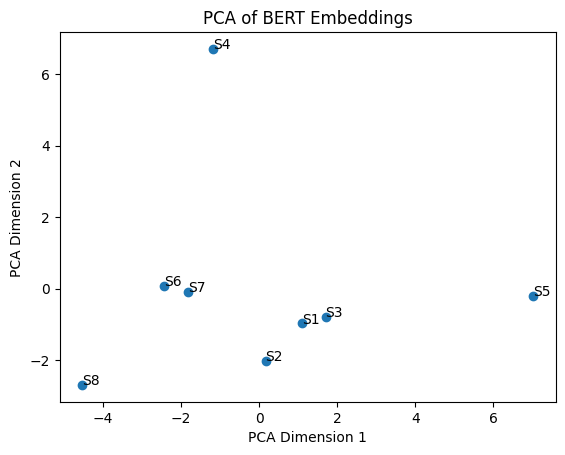

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
sentences=[
"Don't forget to Subscribe our page in www.hh.com",
    
'Get new phone free Click this URL',
"Urgent your Account has been compromised. Verify your details now",
    "Making $5000 a week working from home. No Skills required",
"Your Package delivery failed. Click here to reschedule",
    "Act now this offer expires in 24 hours",
    "Get rich quick with this one simple trick",
    "Warning "
]
embeddings = get_bert_embeddings(sentences)  # Shape: (5, 768)
# Reduce to 2D
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Plot
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1])
for i, txt in enumerate(sentences):
    plt.annotate(f"S{i+1}", (embeddings_pca[i, 0], embeddings_pca[i, 1]))
plt.title("PCA of BERT Embeddings")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.show()